<a href="https://colab.research.google.com/github/abhijit-z/575_project/blob/main/Latest_of_Project_575.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 575 

Group 3
Project members:
- Abhijit A Zarekar
- Ashourina Somo
- Leticia Garcia


The link that we're using to download the data 
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

##Objectives/Main Goals 

The current database that was used for our project was a large clinical database that was undertaken to examine patterns of diabetes care in patients with diabetes admitted to US hospital from 1999 to 2008. 

- Reducing 30 day readmissions of patients with diabetes has the potential to reduce healthcare costs 

## Data Preparation 

###Importing all the libraries that we need for this project 

In [ ]:
#Upload the diabetes.csv to your drive to access the file on google colab 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#All the libraries we're going to need for the project
import pandas as pd
import numpy as np
import collections
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install scipy

In [ ]:
#Loading the data 
# diabetes is our dataframe
diabetes = pd.read_csv('/content/drive/MyDrive/diabetic_data.csv')

In [ ]:
# Size of our dataset: 50 columns and 101766 rows
print(diabetes.shape)

(101766, 50)


In [ ]:
# viewing 1st 5 observations
diabetes.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
#Backup Models in case we want to look original data in the analysis
diabetes_BM = diabetes

###Modifying the database 

In [ ]:
#Since age is ordinal we need to change into a numerical value. So, use the median value instead.
replaceDict = {
    '[0-10)': 5,
    '[10-20)':15,
    '[20-30)':25,
    '[30-40)':35,
    '[40-50)':45,
    '[50-60)':55,
    '[60-70)':65,
    '[70-80)':75,
    '[80-90)':85,
    '[90-100)':95
}
diabetes['age'] =diabetes['age'].apply(lambda x: replaceDict[x])
print(diabetes['age'].head())

0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


In [ ]:
#Deleting duplicates from the dataset
diabetes.dropna(inplace = True)
print('Total data = ', len(diabetes))
print('Unique entries = ', len(np.unique(diabetes['patient_nbr'])))
diabetes.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Length after removing Duplicates:', len(diabetes))

Total data =  101766
Unique entries =  71518
Length after removing Duplicates: 71518


In [ ]:
#We merge similar categories into one category to help analyze the data clearer and make our models more understandable
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) )))))

diabetes = diabetes[~diabetes.discharge_disposition_id.isin([11,13,14,19,20,21])]

diabetes['admission_type_id'] = diabetes['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))

diabetes['admission_source_id'] = diabetes['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    diabetes[col] = diabetes[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20)))


diabetes['change'] = diabetes['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1)


diabetes['diabetesMed'] = diabetes['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1)


diabetes['max_glu_serum'] = diabetes['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0)))

diabetes['A1Cresult'] = diabetes['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [ ]:
#diabetes_bk = diabetes (Back_up)
nrows_d = diabetes.shape[0]
ncols_d = diabetes.shape[1]

In [ ]:
diag_1 = collections.Counter(list(diabetes['diag_1'])).most_common(1)[0][0]
diag_2 = collections.Counter(list(diabetes['diag_2'])).most_common(1)[0][0]
diag_3 = collections.Counter(list(diabetes['diag_3'])).most_common(1)[0][0]
diabetes['diag_1'] = diabetes['diag_1'].apply(lambda x : diag_1 if x == '?' else x)
diabetes['diag_2'] = diabetes['diag_1'].apply(lambda x : diag_2 if x == '?' else x)
diabetes['diag_3'] = diabetes['diag_3'].apply(lambda x : diag_3 if x == '?' else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [ ]:
#diabetes[['weight'] == '?'].count()
wt_miss = diabetes['weight'][diabetes['weight'] == '?'].value_counts() 
wt_miss_percent = wt_miss/nrows_d
print(wt_miss_percent)

?    0.960048
Name: weight, dtype: float64


In [ ]:
diabetes['race'] = diabetes['race'].replace({'?':'other'})
print (sum((diabetes['race'] == '?')))
diabetes['medical_specialty'] = diabetes['medical_specialty'].replace({'?':'other'})
print(sum(diabetes['medical_specialty'] == '?'))

0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Droping weight for the dataframe due to large amount of missing value 
diabetes = diabetes.drop(columns =['weight'])
#Also dropping payer_code, encounter_id, and patient_nbr since it's not something we need for our project
diabete = diabetes.drop(columns = ['payer_code'])
diabete = diabetes.drop(columns = ['encounter_id'])
diabete = diabetes.drop(columns = ['patient_nbr'])

In [ ]:
# listed common speciality with their corresponding department 
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology', 'InternalMedicine', 'Family/GeneralPractice', 'Cardiology',
        'Orthopedics', 'Nephrology', 'Orthopedics-Reconstructive', 
       'Emergency/Trauma', 'Obsterics&Gynecology-GynecologicOnco',
       'ObstetricsandGynecology', 'Urology', 'AllergyandImmunology',
       'Dentistry', 'Anesthesiology', 'PhysicianNotFound', 'Proctology',
       'Rheumatology', 'Obstetrics', 'Radiologist', 'Dermatology',
       'Pathology', 'SportsMedicine', 'Speech', 'OutreachServices',
       'Perinatology', 'Endocrinology-Metabolism', 'DCPTEAM', 'Resident']


missing = ['?']

In [ ]:
diabetes['diag_1'] = diabetes['diag_1'].apply(lambda x : 'other' if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory' if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else     ('respiratory' if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else     ('digestive'   if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else     ('diabetes'    if int(float(x)) == 250
                                        else     ('injury'      if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnancy'        if int(float(x)) in range(630, 680)
                                        else 'other'))))))))))

In [ ]:
diabetes['health_index'] = (1 / (diabetes['number_emergency'] + diabetes['number_inpatient'] + diabetes['number_outpatient']))



diabetes['sev_of_disease'] = (diabetes['time_in_hospital'] + diabetes['num_procedures'] + diabetes['num_medications'] + diabetes['num_lab_procedures'] + diabetes['number_diagnoses'])

diabetes.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,sev_of_disease
0,2278392,8222157,Caucasian,Female,5,5,18,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,diabetes,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,NO,inf,44
1,149190,55629189,Caucasian,Female,15,1,1,7,3,?,other,59,0,18,0,0,0,other,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,>30,inf,89
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,?,other,11,5,13,2,0,1,pregnancy,648,V27,6,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,1,NO,0.333333,37
3,500364,82442376,Caucasian,Male,35,1,1,7,2,?,other,44,1,16,0,0,0,other,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,NO,inf,70
4,16680,42519267,Caucasian,Male,45,1,1,7,1,?,other,51,0,8,0,0,0,neoplasms,197,250,5,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,1,1,NO,inf,65


In [ ]:
diabetes['health_index'] = diabetes['health_index'].replace(np.inf, 0)

In [ ]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,sev_of_disease
0,2278392,8222157,Caucasian,Female,5,5,18,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,diabetes,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,NO,0.000000,44
1,149190,55629189,Caucasian,Female,15,1,1,7,3,?,other,59,0,18,0,0,0,other,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,>30,0.000000,89
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,?,other,11,5,13,2,0,1,pregnancy,648,V27,6,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,1,NO,0.333333,37
3,500364,82442376,Caucasian,Male,35,1,1,7,2,?,other,44,1,16,0,0,0,other,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,NO,0.000000,70
4,16680,42519267,Caucasian,Male,45,1,1,7,1,?,other,51,0,8,0,0,0,neoplasms,197,250,5,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,1,1,NO,0.000000,65


###Getting rid of any unsignificant variables 

In [ ]:
categorical_features = ['gender', 'admission_type_id', 
                        'discharge_disposition_id', 'admission_source_id',
                        'medical_specialty', 'diag_1', 
                        'diag_2', 'diag_3', 'readmitted']

In [ ]:
#We going to use chi-square to help choose variables that are going to be important in our model
for col in categorical_features : 
    data_crosstab = pd.crosstab(diabetes['readmitted'],  
                                diabetes[col], 
                                margins = False) 

    stat, p, dof, expected = stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

0.00015153607660489053 gender is significant
8.460787867684963e-65 admission_type_id is significant
2.3489254647096393e-190 discharge_disposition_id is significant
2.1049560735945086e-113 admission_source_id is significant
1.0652134861068028e-94 medical_specialty is significant
1.0586142934947594e-79 diag_1 is significant
1.0131911285602652e-185 diag_2 is significant
1.3859828753617171e-89 diag_3 is significant
0.0 readmitted is significant


In [ ]:
numeric_features = ['age','time_in_hospital', 'num_lab_procedures', 
                    'num_procedures', 'num_medications', 'number_outpatient', 
                    'number_emergency', 'number_inpatient', 'number_diagnoses', 
                    'health_index', 'sev_of_disease', 
                    'A1Cresult','max_glu_serum','metformin',
                    'repaglinide','nateglinide','chlorpropamide',
                    'glimepiride','acetohexamide','glipizide',
                    'glyburide','tolbutamide','pioglitazone',
                    'rosiglitazone','acarbose','miglitol',
                    'troglitazone','tolazamide','examide',
                    'citoglipton','insulin',
                    'glyburide-metformin','glipizide-metformin',
                    'glimepiride-pioglitazone','metformin-rosiglitazone',
                    'metformin-pioglitazone', 'change', 'diabetesMed']

In [ ]:
rejected_features = []
for col in numeric_features :
    rho , pval = stats.spearmanr(diabetes['readmitted'], diabetes[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

age is significant
time_in_hospital is significant
num_lab_procedures is significant
num_procedures is significant
num_medications is significant
number_outpatient is significant
number_emergency is significant
number_inpatient is significant
number_diagnoses is significant
health_index is significant
sev_of_disease is significant
A1Cresult is significant
max_glu_serum is significant
metformin is significant
repaglinide is significant
nateglinide is significant
chlorpropamide is not significant
glimepiride is not significant
acetohexamide is significant
glipizide is significant
glyburide is significant
tolbutamide is not significant
pioglitazone is significant
rosiglitazone is significant
acarbose is significant
miglitol is significant
troglitazone is not significant
tolazamide is significant
examide is not significant


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


citoglipton is not significant
insulin is significant
glyburide-metformin is not significant
glipizide-metformin is not significant
glimepiride-pioglitazone is not significant
metformin-rosiglitazone is significant
metformin-pioglitazone is not significant
change is significant
diabetesMed is significant


In [ ]:
diabetes_1 = diabetes.filter(['gender', 'age', 
 'admission_type_id', 
 'discharge_disposition_id', 
 'admission_source_id', 'time_in_hospital', 
 'medical_specialty', 'num_lab_procedures', 
 'num_procedures', 'num_medications', 
 'number_outpatient', 'number_emergency', 
 'number_inpatient', 'diag_1', 'diag_2', 
 'diag_3', 'number_diagnoses', 'max_glu_serum',
 'A1Cresult', 'metformin', 'repaglinide',
 'nateglinide', 'chlorpropamide', 'glipizide',
 'glyburide', 
 'tolazamide', 'insulin', 
 'change', 'diabetesMed', 'race', 
 'health_index', 'sev_of_disease','readmitted'], axis=1)

In [ ]:
diabetes_1.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glipizide,glyburide,tolazamide,insulin,change,diabetesMed,race,health_index,sev_of_disease,readmitted
0,Female,5,5,18,1,1,Pediatrics-Endocrinology,41,0,1,0,0,0,diabetes,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,Caucasian,0.000000,44,NO
1,Female,15,1,1,7,3,other,59,0,18,0,0,0,other,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,Caucasian,0.000000,89,>30
2,Female,25,1,1,7,2,other,11,5,13,2,0,1,pregnancy,648,V27,6,0,0,-20,-20,-20,-20,0,-20,-20,-20,-1,1,AfricanAmerican,0.333333,37,NO
3,Male,35,1,1,7,2,other,44,1,16,0,0,0,other,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,Caucasian,0.000000,70,NO
4,Male,45,1,1,7,1,other,51,0,8,0,0,0,neoplasms,197,250,5,0,0,-20,-20,-20,-20,0,-20,-20,0,1,1,Caucasian,0.000000,65,NO


##Statistic Analysis

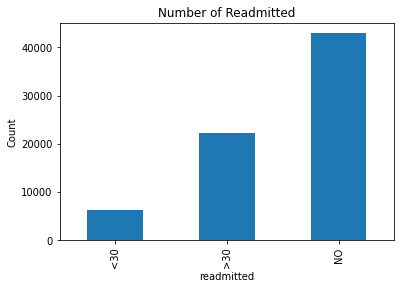

In [ ]:
diabetes_BM.groupby('readmitted').size().plot(kind = 'bar')
plt.ylabel('Count')
plt.title('Number of Readmitted');

In [ ]:
diabetes['readmitted'] = diabetes['readmitted'].replace({'NO':0})
print(sum(diabetes['readmitted'] == 0))

41901


In [ ]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,sev_of_disease
0,2278392,8222157,Caucasian,Female,5,5,18,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,diabetes,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,0,0.000000,44
1,149190,55629189,Caucasian,Female,15,1,1,7,3,?,other,59,0,18,0,0,0,other,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,>30,0.000000,89
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,?,other,11,5,13,2,0,1,pregnancy,648,V27,6,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,1,0,0.333333,37
3,500364,82442376,Caucasian,Male,35,1,1,7,2,?,other,44,1,16,0,0,0,other,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,0,0.000000,70
4,16680,42519267,Caucasian,Male,45,1,1,7,1,?,other,51,0,8,0,0,0,neoplasms,197,250,5,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,1,1,0,0.000000,65


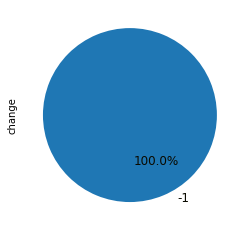

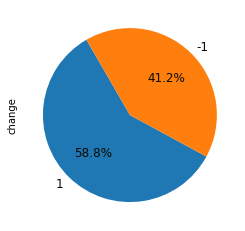

In [ ]:
fig = plt.figure()
ax = diabetes[(diabetes.readmitted == 0) & (diabetes.diabetesMed == -1)].change.value_counts().\
     plot.pie(autopct="%1.1f%%", startangle=120, textprops={'fontsize': 12, 'color':'#0a0a00'},)

fig = plt.figure()
ax = diabetes[(diabetes.readmitted == 0) & (diabetes.diabetesMed == 1)].change.value_counts().\
     plot.pie(autopct="%1.1f%%", startangle=120,textprops={'fontsize': 12, 'color':'#0a0a00'},)

In [ ]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,sev_of_disease
0,2278392,8222157,Caucasian,Female,5,5,18,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,diabetes,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,0,0.000000,44
1,149190,55629189,Caucasian,Female,15,1,1,7,3,?,other,59,0,18,0,0,0,other,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,>30,0.000000,89
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,?,other,11,5,13,2,0,1,pregnancy,648,V27,6,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-1,1,0,0.333333,37
3,500364,82442376,Caucasian,Male,35,1,1,7,2,?,other,44,1,16,0,0,0,other,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,10,-20,-20,-20,-20,-20,1,1,0,0.000000,70
4,16680,42519267,Caucasian,Male,45,1,1,7,1,?,other,51,0,8,0,0,0,neoplasms,197,250,5,0,0,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,-20,-20,-20,-20,-20,0,-20,-20,-20,-20,-20,1,1,0,0.000000,65


In [ ]:
diabetes_1.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glipizide,glyburide,tolazamide,insulin,change,diabetesMed,race,health_index,sev_of_disease,readmitted
0,Female,5,5,18,1,1,Pediatrics-Endocrinology,41,0,1,0,0,0,diabetes,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,Caucasian,0.000000,44,NO
1,Female,15,1,1,7,3,other,59,0,18,0,0,0,other,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,Caucasian,0.000000,89,>30
2,Female,25,1,1,7,2,other,11,5,13,2,0,1,pregnancy,648,V27,6,0,0,-20,-20,-20,-20,0,-20,-20,-20,-1,1,AfricanAmerican,0.333333,37,NO
3,Male,35,1,1,7,2,other,44,1,16,0,0,0,other,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,Caucasian,0.000000,70,NO
4,Male,45,1,1,7,1,other,51,0,8,0,0,0,neoplasms,197,250,5,0,0,-20,-20,-20,-20,0,-20,-20,0,1,1,Caucasian,0.000000,65,NO


In [ ]:
diabetes_1['gender'] = diabetes_1['gender'].replace('Female',0)
diabetes_1['gender'] = diabetes_1['gender'].replace('Male',1)
diabetes_1['gender'] = diabetes_1['gender'].replace('Unknown/Invalid',2)


In [ ]:
diabetes_1['race'].unique()

array(['Caucasian', 'AfricanAmerican', 'other', 'Other', 'Asian',
       'Hispanic'], dtype=object)

In [ ]:
#Converting every categorical to a interger 
diabetes_1['race'] = diabetes_1['race'].replace('AfricanAmerican',0)
diabetes_1['race'] = diabetes_1['race'].replace('Asian',1)
diabetes_1['race'] = diabetes_1['race'].replace('Caucasian',2)
diabetes_1['race'] = diabetes_1['race'].replace('Hispanic',3)
diabetes_1['race'] = diabetes_1['race'].replace(['Other','other'],4)


In [ ]:
#Something we wanted to look at 
diabetes_1['diag_3'].unique()

array(['250', '255', 'V27', '403', 'V45', '38', '486', '996', '197',
       '250.6', '427', '627', '414', '416', '714', '428', '582', 'V43',
       '250.01', '263', '250.42', '276', '482', '401', '250.41', '585',
       '781', '278', '998', '568', '682', '618', '250.02', '305', '707',
       '496', '715', '424', '518', '553', '794', '411', 'V42', '531',
       '511', '490', '562', '250.8', '599', '250.7', '250.52', '491',
       '581', '420', '8', '724', '730', '789', '131', '250.82', '999',
       '41', '493', '250.03', '786', '529', 'E888', '425', '595', '303',
       '560', '711', '492', '332', '296', '438', '362', '250.4', '654',
       '244', 'V70', '737', '625', '681', '250.51', '404', 'V10', '810',
       '280', '440', '785', '588', '569', '272', '997', '250.43', '918',
       '584', '54', '788', '426', '722', '250.92', '461', '535', '787',
       '891', '284', '458', '648', '780', '285', '593', '413', '664',
       '564', '201', '356', 'V15', '292', '196', '782', '784', '473',


In [ ]:
diabetes_1['medical_specialty'] = diabetes_1['medical_specialty'].replace(pediatrics,0)
diabetes_1['medical_specialty'] = diabetes_1['medical_specialty'].replace(psychic,1)
diabetes_1['medical_specialty'] = diabetes_1['medical_specialty'].replace(neurology,2)
diabetes_1['medical_specialty'] = diabetes_1['medical_specialty'].replace(surgery,3)
diabetes_1['medical_specialty'] = diabetes_1['medical_specialty'].replace(ungrouped, 4)
diabetes_1['medical_specialty'] = diabetes_1['medical_specialty'].replace('other',5)
print(type(diabetes_1['medical_specialty']))

<class 'pandas.core.series.Series'>


In [ ]:
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('diabetes',0)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('pregnancy',1)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('neoplasms',2)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('circulatory',3)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('respiratory',4)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('injury',5)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('musculoskeletal',6)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('digestive',7)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('genitourinary',8)
diabetes_1['diag_1'] = diabetes_1['diag_1'].replace('other',9)

print(diabetes_1['diag_1'].unique())
diabetes_1.head()
#diabetes_1['medical_specialty'].unique()

[0 9 1 2 3 4 5 6 7 8]


,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glipizide,glyburide,tolazamide,insulin,change,diabetesMed,race,health_index,sev_of_disease,readmitted
0,0,5,5,18,1,1,0,41,0,1,0,0,0,0,250.83,250,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,2,0.000000,44,NO
1,0,15,1,1,7,3,5,59,0,18,0,0,0,9,276,255,9,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,2,0.000000,89,>30
2,0,25,1,1,7,2,5,11,5,13,2,0,1,1,648,V27,6,0,0,-20,-20,-20,-20,0,-20,-20,-20,-1,1,0,0.333333,37,NO
3,1,35,1,1,7,2,5,44,1,16,0,0,0,9,8,403,7,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,2,0.000000,70,NO
4,1,45,1,1,7,1,5,51,0,8,0,0,0,2,197,250,5,0,0,-20,-20,-20,-20,0,-20,-20,0,1,1,2,0.000000,65,NO


In [ ]:
diabetes_1 = diabetes_1.drop(['diag_2','diag_3'], axis=1)
#diabetes_1['diag_2'].unique()

In [ ]:
diabetes_1.head()
diabetes_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70434 entries, 0 to 101765
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gender                    70434 non-null  int64  
 1   age                       70434 non-null  int64  
 2   admission_type_id         70434 non-null  int64  
 3   discharge_disposition_id  70434 non-null  int64  
 4   admission_source_id       70434 non-null  int64  
 5   time_in_hospital          70434 non-null  int64  
 6   medical_specialty         70434 non-null  int64  
 7   num_lab_procedures        70434 non-null  int64  
 8   num_procedures            70434 non-null  int64  
 9   num_medications           70434 non-null  int64  
 10  number_outpatient         70434 non-null  int64  
 11  number_emergency          70434 non-null  int64  
 12  number_inpatient          70434 non-null  int64  
 13  diag_1                    70434 non-null  int64  
 14  numbe

In [ ]:
diabetes_b = diabetes
diabetes_b['readmitted'] = diabetes_b['readmitted'].replace({'<30':1})
diabetes_b['readmitted'] = diabetes_b['readmitted'].replace({'>30':1})

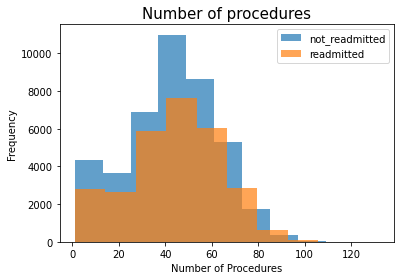

In [ ]:
plt.figure()
plt.hist(diabetes_b[diabetes_b['readmitted'] == 0]["num_lab_procedures"], alpha=0.7, label='not_readmitted');
plt.hist(diabetes_b[diabetes_b['readmitted'] == 1]["num_lab_procedures"], alpha=0.7, label='readmitted');

plt.title('Number of procedures', fontsize=15)
plt.xlabel("Number of Procedures")
plt.ylabel("Frequency")

plt.legend();

##Creating the training and test set

In [ ]:
diabetes_1['readmitted'] = diabetes_1['readmitted'].replace({'NO':0})
diabetes_1['readmitted'] = diabetes_1['readmitted'].replace({'>30':1})
diabetes_1['readmitted'] = diabetes_1['readmitted'].replace({'<30':0})
# our class of interest is patients readmitted after 30 days because 
# patients who get admitted after the 30 day period are more likely waiting for 
# their condition to get worse so they most likely pay more compared to other patients.

In [ ]:
diabetes_1['readmitted'].value_counts()

0    48194
1    22240
Name: readmitted, dtype: int64

In [ ]:
df_majority = diabetes_1[diabetes_1.readmitted == 0]
df_minority = diabetes_1[diabetes_1.readmitted == 1]

from sklearn.utils import resample
diabetes_1_sample = resample(df_majority, replace=False, n_samples=22240)

diabetes_1_sampled = pd.concat([diabetes_1_sample, df_minority])

In [ ]:
print(diabetes_1_sampled['readmitted'].value_counts())

1    22240
0    22240
Name: readmitted, dtype: int64


In [ ]:
print(diabetes_1_sampled.shape)
print(diabetes_1_sampled['readmitted'].value_counts())

(44480, 31)
1    22240
0    22240
Name: readmitted, dtype: int64


In [ ]:
features = ['gender','age','admission_type_id','discharge_disposition_id','admission_source_id',
            'time_in_hospital','medical_specialty','num_lab_procedures','num_procedures',
            'num_medications','number_outpatient','number_emergency','number_inpatient','diag_1','number_diagnoses',
            'max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide','chlorpropamide','glipizide','glyburide',
            'tolazamide','insulin','change','diabetesMed','race','health_index','sev_of_disease']
X = diabetes_1_sampled[features]
Y = diabetes_1_sampled['readmitted']

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(31136, 30)
(13344, 30)
(31136,)
(13344,)


In [ ]:
diabetes_1.head()

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glipizide,glyburide,tolazamide,insulin,change,diabetesMed,race,health_index,sev_of_disease,readmitted
0,0,5,5,18,1,1,0,41,0,1,0,0,0,0,1,0,0,-20,-20,-20,-20,-20,-20,-20,-20,-1,-1,2,0.000000,44,0
1,0,15,1,1,7,3,5,59,0,18,0,0,0,9,9,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,2,0.000000,89,1
2,0,25,1,1,7,2,5,11,5,13,2,0,1,1,6,0,0,-20,-20,-20,-20,0,-20,-20,-20,-1,1,0,0.333333,37,0
3,1,35,1,1,7,2,5,44,1,16,0,0,0,9,7,0,0,-20,-20,-20,-20,-20,-20,-20,10,1,1,2,0.000000,70,0
4,1,45,1,1,7,1,5,51,0,8,0,0,0,2,5,0,0,-20,-20,-20,-20,0,-20,-20,0,1,1,2,0.000000,65,0


##Models and Classification

###Models and Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
#Baseline Model 
from sklearn.neighbors import KNeighborsClassifier
model_b = KNeighborsClassifier(n_neighbors=5)

#Cross Validation Accuracy 
knn_score = cross_val_score(model_b, X_train, Y_train, cv=5, scoring = 'accuracy').mean()
print(knn_score)

0.5242162061975739


[[3614 3119]
 [3184 3427]]


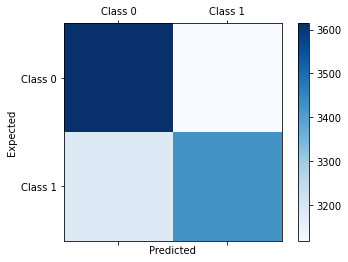

In [ ]:
result_2 = model_b.fit(X_train,Y_train)
y = result_2.predict(X_test)

#Recall Score 
rc_score_2 = recall_score(Y_test,y, average='macro')

#Precision Score 
p_score_2 = precision_score(Y_test,y,average='macro')

#F1 score 
f1_score_2 = f1_score(Y_test,y,average='macro')

#ROC AUC Score 
roc_auc_score_2 = roc_auc_score(Y_test, y, multi_class='ovo')

#Confusion Matrix 
cfm = confusion_matrix(Y_test, y)
print(cfm)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
print(rc_score_2, p_score_2 )

0.5275688528246953 0.5275763831978404


In [ ]:
#Model 2
from sklearn.naive_bayes import GaussianNB
model_1 = GaussianNB()

#Cross Validation Acccuracy score 
GNB_score = cross_val_score(model_1, X_train, Y_train, cv = 5, scoring = 'accuracy').mean()
print(GNB_score)

0.5459919762271724


[[5690 1043]
 [4938 1673]]


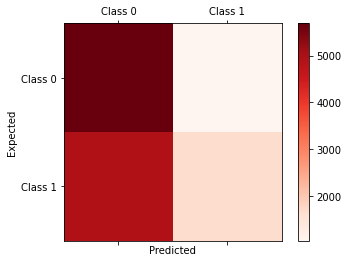

In [ ]:
result_1 = model_1.fit(X_train,Y_train)
y = result_1.predict(X_test)

#Recall Score 
rc_score_1 = recall_score(Y_test,y, average='macro')

#Precision Score 
p_score_1 = precision_score(Y_test,y,average='macro')

#F1 score 
f1_score_1 = f1_score(Y_test,y,average='macro')

#ROC AUC Score 
roc_auc_score_1 = roc_auc_score(Y_test, y, multi_class='ovo')

#Confusion Matrix 
cfm = confusion_matrix(Y_test, y)
print(cfm)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm, cmap=plt.cm.Reds)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
#plt.title("Confusion Matrix for Naive-Bayes model")
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
print(rc_score_1, p_score_1 )

0.5490772089229337 0.5756788137927824


In [ ]:
#Model 3
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression(max_iter = 1000)


lr_score = cross_val_score(model_3, X_train, Y_train, cv=5, scoring = 'accuracy').mean()
print(lr_score)

0.5761820274461013


[[4068 2665]
 [2980 3631]]


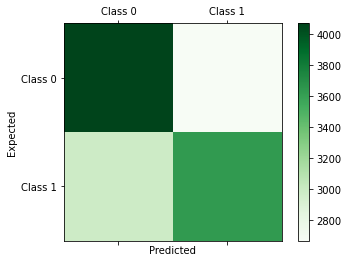

In [ ]:
result_3 = model_3.fit(X_train,Y_train)
y = result_3.predict(X_test)

#Recall Score 
rc_score_3 = recall_score(Y_test,y, average='macro')

#Precision Score 
p_score_3 = precision_score(Y_test,y,average='macro')

#F1 score 
f1_score_3 = f1_score(Y_test,y,average='macro')

#ROC AUC Score 
roc_auc_score_3 = roc_auc_score(Y_test, y, multi_class='ovo')

#Confusion Matrix 
cfm = confusion_matrix(Y_test, y)
print(cfm)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm, cmap=plt.cm.Greens)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
#Model 4
from sklearn import svm
model_4 = svm.SVC(kernel='linear', C = 0.01)
svm_score = cross_val_score(model_4, X_train, Y_train, cv=5, scoring = 'accuracy').mean()
print(svm_score)

0.561151001001605


[[5258 1475]
 [4317 2294]]


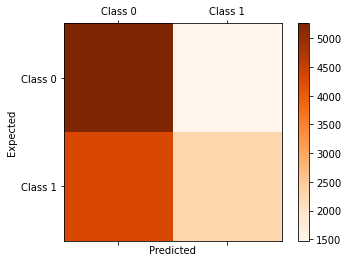

In [ ]:
# Result of SVM with Linear kernel without hyperparamter tuning
result_4 = model_4.fit(X_train,Y_train)
y = result_4.predict(X_test)

#Recall Score 
rc_score_4 = recall_score(Y_test,y, average='macro')

#Precision Score 
p_score_4 = precision_score(Y_test,y,average='macro')

#F1 score 
f1_score_4 = f1_score(Y_test,y,average='macro')

#ROC AUC Score 
roc_auc_score_4 = roc_auc_score(Y_test, y, multi_class='ovo')

#Confusion Matrix 
cfm = confusion_matrix(Y_test, y)
print(cfm)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm, cmap=plt.cm.Oranges)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

### SVM with Hyperparameter tuning:

In [ ]:
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
#grid.fit(X_train, Y_train)
svm_score_g = cross_val_score(grid, X_train, Y_train, cv=5, scoring = 'accuracy')
print(svm_score_g)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.548, total=  41.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.538, total=  41.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.547, total=  41.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.520, total=  41.5s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.528, total=  41.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.562, total=  40.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.557, total=  41.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.552, total=  41.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.553, total=  41.3s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 46.8min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.532, total=  39.9s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.535, total=  40.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.534, total=  40.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.515, total=  40.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.530, total=  39.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.544, total=  39.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.560, total=  40.2s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.554, total=  40.3s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.549, total=  40.7s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 45.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.539, total=  40.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.2s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.542, total=  39.7s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.543, total=  40.3s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.523, total=  40.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.523, total=  40.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.548, total=  39.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.558, total=  39.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.566, total=  39.6s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.553, total=  39.9s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 45.8min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.534, total=  40.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.544, total=  40.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.530, total=  40.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.530, total=  40.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.543, total=  40.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.545, total=  40.2s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.560, total=  39.5s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.559, total=  39.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.540, total=  40.3s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 45.9min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.534, total=  39.8s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.8s remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.536, total=  40.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.532, total=  40.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.535, total=  39.9s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.526, total=  39.9s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.548, total=  39.9s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.556, total=  40.0s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.556, total=  39.8s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.548, total=  40.1s
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 45.6min finished


[0.58092486 0.58310583 0.57812751 0.59097479 0.57684278]


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.539, total= 1.1min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.552, total= 1.1min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.532, total= 1.1min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.524, total= 1.1min
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.523, total= 1.0min
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.551, total= 1.0min
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.560, total= 1.0min
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.554, total= 1.0min
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] ...... C=0.1, gamma=0.001, kernel=rbf, score=0.562, total= 1.0min
[CV] C=0.1, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 74.5min finished


              precision    recall  f1-score   support

           0       0.57      0.61      0.59      6637
           1       0.59      0.55      0.57      6707

    accuracy                           0.58     13344
   macro avg       0.58      0.58      0.58     13344
weighted avg       0.58      0.58      0.58     13344

[[4030 2607]
 [2993 3714]]


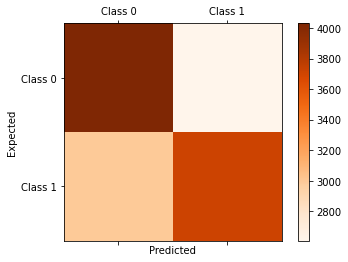

In [ ]:
grid_result = grid.fit(X_train, Y_train)
y = grid_result.predict(X_test)

print(classification_report(Y_test, y))

#Recall Score 
rc_score_4 = recall_score(Y_test,y, average='macro')

#Precision Score 
p_score_4 = precision_score(Y_test,y,average='macro')

#F1 score 
f1_score_4 = f1_score(Y_test,y,average='macro')

#ROC AUC Score 
roc_auc_score_4 = roc_auc_score(Y_test, y, multi_class='ovo')

#Confusion Matrix 
cfm = confusion_matrix(Y_test, y)
print(cfm)
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cfm, cmap=plt.cm.Oranges)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
# SVM with hyperparameter tuning - Test data accuracy Score
accuracy_score(Y_test, y)

0.580335731414868

In [ ]:
SVM_hyp_tuned_cv_score = np.mean([0.58092486, 0.58310583, 0.57812751, 0.59097479, 0.57684278])
print(SVM_hyp_tuned_cv_score)

0.581995154


In [ ]:
SVM_hyp_t_cm = np.array([[4030, 2607],
                        [2993, 3714]])
mht = SVM_hyp_t_cm
SVM_hyp_t_rec = mht[1,1]/(mht[1,1]+mht[1,0])
SVM_hyp_t_pre = mht[1,1]/(mht[1,1]+mht[0,1])
SVM_hyp_t_f1score = mht[1,1]/(mht[1,1] + 0.5*(mht[1,0]+mht[0,1]))
print(SVM_hyp_t_rec, SVM_hyp_t_pre, SVM_hyp_t_f1score)

0.5537498136275533 0.5875652586616041 0.5701565858151674


#### Old SVM results
svm_old = np.array([[5175, 1487],
                    [4372, 2310]])

rc_score_4 = svm_old[1,1]/(svm_old[1,1]+svm_old[1,0])
p_score_4 = svm_old[1,1]/(svm_old[1,1]+svm_old[0,1])
f1_score_4 = svm_old[1,1]/(svm_old[1,1] + 0.5*(svm_old[1,0]+svm_old[0,1]))
print(rc_score_4, p_score_4, f1_score_4)

###Model 4 (Unsupervised Model)


In [ ]:
##Model 5 (Unsupervised Model)
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=3, random_state=0, n_init=10).fit(X)

clusters = y_pred.labels_


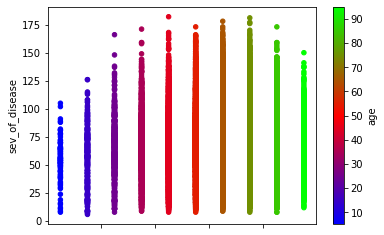

In [ ]:
X['clusters'] = clusters
ax = X.plot(kind ='scatter', x ='age', y='sev_of_disease', c='age', colormap = plt.cm.brg)


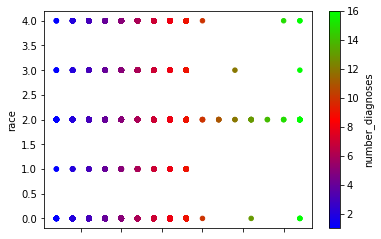

In [ ]:
X['clusters'] = clusters
ax = X.plot(kind ='scatter', x ='number_diagnoses', y='race', c='number_diagnoses', colormap = plt.cm.brg)
# The scatterplot indicates the increase in the severity of the disease with the increase in the number of lab procedures

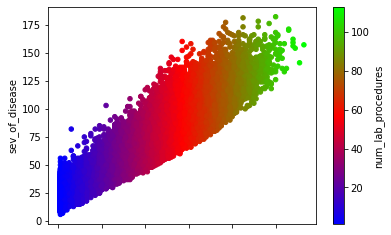

In [ ]:
X['clusters'] = clusters
ax = X.plot(kind ='scatter', x ='num_lab_procedures', y='sev_of_disease', c='num_lab_procedures', colormap = plt.cm.brg)
# The scatterplot indicates the increase in the severity of the disease with the increase in the number of lab procedures

###Classification

Analysis 

In [ ]:
#svm_score = 0.5621144798084955
print(knn_score, GNB_score, lr_score, svm_score, SVM_hyp_tuned_cv_score)

0.5242162061975739 0.5459919762271724 0.5761820274461013 0.561151001001605 0.581995154


Text(0, 0.5, 'Cross-Validated Accuracy')

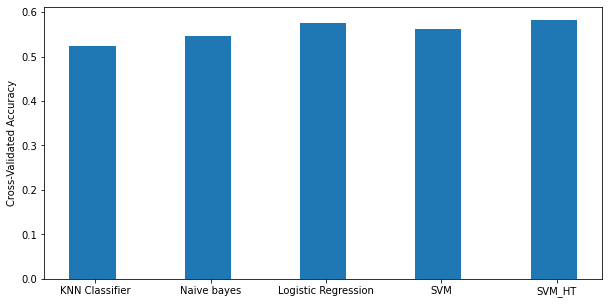

In [ ]:
plt.figure(figsize=(10, 5))
x_axis = np.arange(5)
y_axis = [knn_score, GNB_score, lr_score, svm_score, SVM_hyp_tuned_cv_score]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.05/2, ('KNN Classifier', 'Naive bayes' , 'Logistic Regression', 'SVM', 'SVM_HT'))
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
print(rc_score_2, rc_score_1, rc_score_3, rc_score_4, SVM_hyp_t_rec)

0.5275688528246953 0.5490772089229337 0.5767122238851248 0.5639635887628429 0.5537498136275533


Text(0, 0.5, 'Recall Scores')

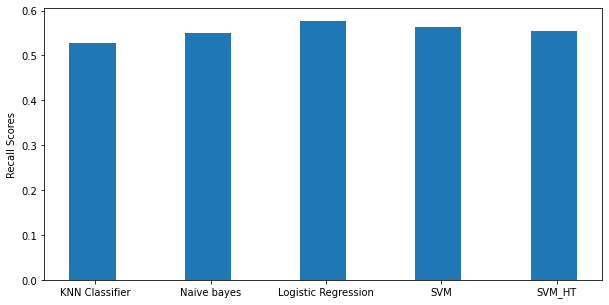

In [ ]:
plt.figure(figsize=(10, 5))
x_axis = np.arange(5)
y_axis = [rc_score_2, rc_score_1, rc_score_3, rc_score_4, SVM_hyp_t_rec]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.05/2, ('KNN Classifier', 'Naive bayes', 'Logistic Regression', 'SVM', 'SVM_HT'))
plt.ylabel('Recall Scores')

In [ ]:
print(p_score_2, p_score_1,p_score_3,p_score_4, SVM_hyp_t_pre)

0.5275763831978404 0.5756788137927824 0.5769501959336378 0.5788939451773331 0.5875652586616041


Text(0, 0.5, 'Precision Scores')

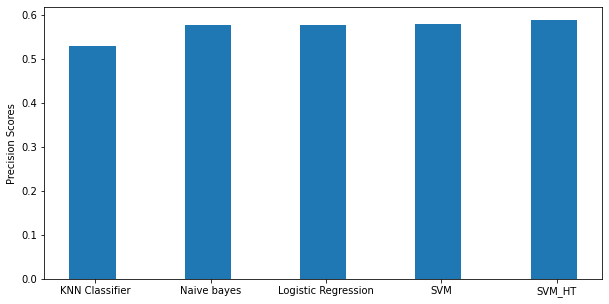

In [ ]:
plt.figure(figsize=(10, 5))
x_axis = np.arange(5)
y_axis = [p_score_2, p_score_1,p_score_3, p_score_4, SVM_hyp_t_pre]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.05/2., ( 'KNN Classifier', 'Naive bayes', 'Logistic Regression', 'SVM', 'SVM_HT'))
plt.ylabel('Precision Scores')


In [ ]:
print(f1_score_2, f1_score_1 , f1_score_3, f1_score_4, SVM_hyp_t_f1score)

0.5275600969821681 0.5071178140969501 0.5765092422098493 0.5434203717172749 0.5701565858151674


Text(0, 0.5, 'F1 Scores')

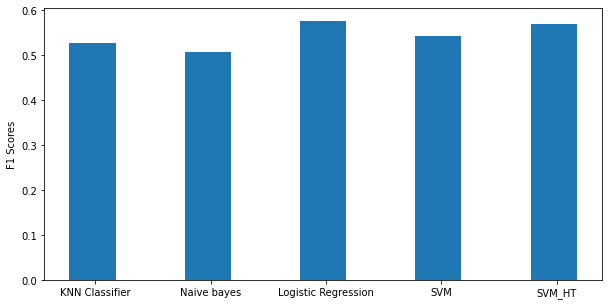

In [ ]:
plt.figure(figsize=(10, 5))
x_axis = np.arange(5)
y_axis = [f1_score_2, f1_score_1, f1_score_3,f1_score_4, SVM_hyp_t_f1score]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.05/2, ( 'KNN Classifier', 'Naive bayes','Logistic Regression', 'SVM', 'SVM_HT'))
plt.ylabel('F1 Scores')

In [ ]:
 print(roc_auc_score_2, roc_auc_score_1, roc_auc_score_3, roc_auc_score_4)

0.5573769637406838 0.5278376918474244 0.574088075011544 0.5630963951627587


Text(0, 0.5, 'ROC AUC Scores')

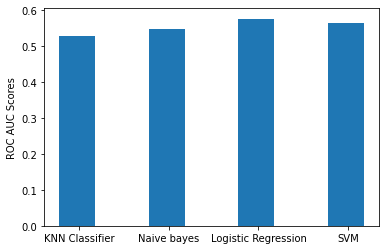

In [ ]:
x_axis = np.arange(4)
y_axis = [roc_auc_score_2, roc_auc_score_1 ,roc_auc_score_3,roc_auc_score_4]
plt.bar(x_axis, y_axis, width=0.4)
plt.xticks(x_axis + 0.05/2., ( 'KNN Classifier', 'Naive bayes','Logistic Regression', 'SVM'))
plt.ylabel('ROC AUC Scores')